In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Plot settings
matplotlib.rcParams['figure.figsize'] = [14.0, 8.0]
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['lines.linewidth'] = 2.0
# Interactive plotting
import cufflinks as cf
cf.set_config_file(offline=True)
cf.set_config_file(theme = 'pearl')
#cf.getThemes() 

### Contents:

1. Discounting curve
2. CDS historical spreads uploading
3. CDS term structure uploading
4. Hazard rates bootstrapping
    - 4.1. Helper functions
    - 4.2. Hazard rates bootstrapping
    - 4.3. Survival metrics visualized
    - 4.4. Effect of recovery rate

### 1. Discounting curve - Bloomberg (SWAP SOFR curve - S490)

In [2]:
curve = pd.read_excel(r"Input Data\SOFR_curve_BBB_S490_mid.xlsx")

In [3]:
## Set tenors in years numberically
tenors = {
    '1M': 1/12, 
    '2M': 1/6,
    '3M': 1/4,
    '4M': 1/3,
    '5M': 5/12,
    '6M': 0.5,
    '7M': 7/12,
    '8M': 1/3,
    '9M': 3/4,
    '10M': 10/12,
    '11M': 11/12,
    '12M': 1.0,
    '18M': 1.5,
    '2Y': 2.0,
    '3Y': 3.0,
    '4Y': 4.0,
    '5Y': 5.0,
    '6Y': 6.0,
    '7Y': 7.0,
    '8Y': 8.0,
    '9Y': 9.0,
    '10Y': 10.0,
}

curve['maturity'] = curve['Tenor'].apply(lambda x: tenors[x])

In [4]:
## Calculate discounting factors for each tenor

curve = curve.sort_values(['maturity'], ascending=True)
curve['Disc_factor'] = 0

for i in range(curve.shape[0]):
    if i==0:
        curve['Disc_factor'][i] = np.exp(-curve['Yield'][i]/100*curve['maturity'][i])
    else:
        curve['Disc_factor'][i] = np.exp(-curve['Yield'][i]/100*(curve['maturity'][i]-curve['maturity'][i-1]))\
        *curve['Disc_factor'][i-1]

In [5]:
# write into csv file for futher use
curve.to_csv('Disc_curve.csv')

curve

,Tenor,Description,Yield,maturity,Disc_factor
0,1M,US0FRA BGN Curncy,5.358,0.083333,0.995545
1,2M,US0FRB BGN Curncy,5.356,0.166667,0.991111
2,3M,US0FRC BGN Curncy,5.347,0.250000,0.986705
3,4M,US0FRD BGN Curncy,5.306,0.333333,0.982352
7,8M,US0FRH BGN Curncy,5.032,0.333333,0.982012
4,5M,US0FRE BGN Curncy,5.239,0.416667,0.978072
5,6M,US0FRF BGN Curncy,5.170,0.500000,0.973868
6,7M,US0FRG BGN Curncy,5.102,0.583333,0.969736
8,9M,US0FRI BGN Curncy,4.965,0.750000,0.961905
9,10M,US0FRJ BGN Curncy,4.897,0.833333,0.957988


### 2.  CDS historical spreads uploading - source Datagrapple.com

In [6]:
# reading data from 'csv files'
names = ['UAE','QATAR','SAUDI','OMAN','BAHRAIN']
CDS_df = pd.DataFrame(columns = ['Date']+names)

for name in names:
    df = pd.read_csv(r"Input Data\%s CDS.csv" %(name))
    CDS_df[name] = df.spread


CDS_df['Date'] = pd.to_datetime(df.valueDate)

In [7]:
# take the last 5 years of the data

CDS_df = CDS_df[CDS_df['Date'] >= '2018-12-22']

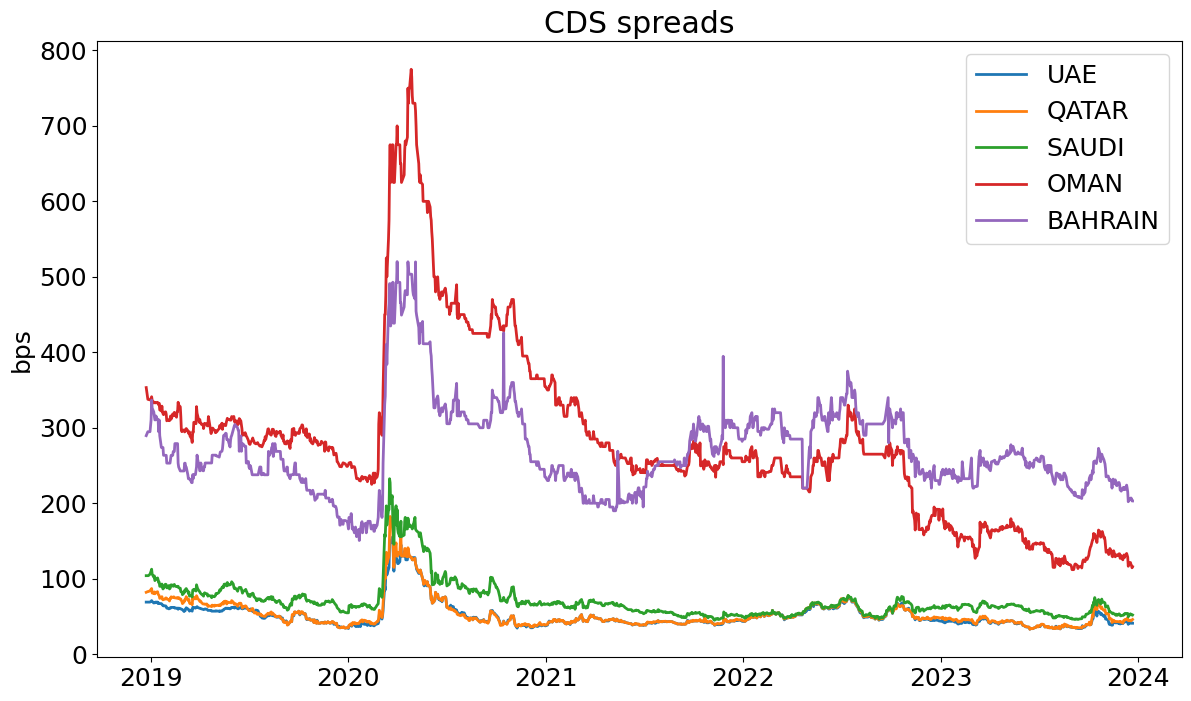

In [8]:
# visualize

plt.plot(CDS_df['Date'],CDS_df[names])
plt.legend(CDS_df[names])
plt.title('CDS spreads')
plt.ylabel('bps')
plt.show()

In [9]:
# take weekly differences and show the data head
CDS_df.iloc[::5, :].diff(1).head()

,Date,UAE,QATAR,SAUDI,OMAN,BAHRAIN
3282,NaT,NaN,NaN,NaN,NaN,NaN
3287,10 days,2.0,5.0,8.580638,-12.141409,47.080508
3292,7 days,-2.0,-5.0,-14.126484,-8.143205,-26.242212
3297,7 days,-2.0,-4.5,-3.022604,-0.519924,-0.021884
3302,7 days,-2.0,-5.5,-9.058652,-13.828313,-36.492647


In [10]:
# drop NaN
CDS_df.iloc[::5, :].diff(1).dropna().head()

,Date,UAE,QATAR,SAUDI,OMAN,BAHRAIN
3287,10 days,2.0,5.0,8.580638,-12.141409,47.080508
3292,7 days,-2.0,-5.0,-14.126484,-8.143205,-26.242212
3297,7 days,-2.0,-4.5,-3.022604,-0.519924,-0.021884
3302,7 days,-2.0,-5.5,-9.058652,-13.828313,-36.492647
3307,7 days,-4.0,1.0,1.509120,-9.391352,-20.741094


In [11]:
# take weekly differences and show the data tail
CDS_df.iloc[::5, :].diff(1).tail()

,Date,UAE,QATAR,SAUDI,OMAN,BAHRAIN
4522,7 days,-0.999998,-0.749996,-2.250000,-1.0,-8.75
4527,7 days,-0.999999,-0.250003,-1.449998,-0.5,-6.25
4532,7 days,1.999997,1.500000,1.699999,-3.0,3.00
4537,7 days,-3.000000,0.000001,-3.000000,-11.5,-18.00
4542,7 days,1.500000,0.999999,2.999999,-2.0,1.00


In [12]:
### write into .csv file for further correlation analysis in the Matlab software

CDS_df.iloc[::5, :].diff(1).dropna().to_csv('CDS_spreads_5Y.csv')

### 3. CDS term structure uploading

In [13]:
# read xlxl file

CDS_market = pd.read_excel(r"Input Data\CDS_term_structure.xlsx")

In [14]:
# calculate mid prices
CDS_market['mid'] = (CDS_market['BID(bps)'] + CDS_market['ASK(bps)'])/2

# ransform tenors into numeric values in years
tenors = {
    '6mo': 0.5, 
    '1yr': 1.0,
    '2yr': 2.0,
    '3yr': 3.0,
    '4yr': 4.0,
    '5yr': 5.0,
    '7yr': 7.0,
    '10yr': 10.0,
}

CDS_market['tenor'] = CDS_market['TERM'].apply(lambda x: tenors[x])


In [15]:
CDS_market

,COUNTRY,BBG ID,CURRENCY,TERM,TICKER,CONTRIBUTOR,BID(bps),ASK(bps),mid,tenor
0,QATAR,307687,USD,6mo,CT990879,CMAN,10.210,18.130,14.1700,0.5
1,QATAR,307687,USD,1yr,CQTA1U1,CMAN,11.690,18.540,15.1150,1.0
2,QATAR,307687,USD,2yr,CQTA1U2,CMAN,18.620,25.370,21.9950,2.0
3,QATAR,307687,USD,3yr,CQTA1U3,CMAN,26.580,32.990,29.7850,3.0
4,QATAR,307687,USD,4yr,CQTA1U4,CMAN,34.050,39.860,36.9550,4.0
5,QATAR,307687,USD,5yr,CQTA1U5,CBIN,43.278,46.851,45.0645,5.0
6,QATAR,307687,USD,7yr,CQTA1U7,CMAN,59.880,67.190,63.5350,7.0
7,QATAR,307687,USD,10yr,CQTR1U10,CMAN,73.550,83.370,78.4600,10.0
8,SAUDI,307693,USD,6mo,CT990871,CMAN,12.970,18.890,15.9300,0.5
9,SAUDI,307693,USD,1yr,CT965291,CMAN,18.690,24.130,21.4100,1.0


### 4. Hazard rates bootstrapping

### 4.1 Helper functions

#### Helper functions to calculate discounting factors, default probabilities, survival and to bootstrap hazard rates

Discount Factors
For discounting factors, we'll do a log-linear interpolation for $\tau_i<\tau<\tau_{i+1}$,
$$
\ln D F(0, \tau)=\frac{\tau-\tau_i}{\tau_{i+1}-\tau_i} \ln D F\left(0, \tau_{i+1}\right)+\frac{\tau_{i+1}-\tau}{\tau_{i+1}-\tau_i} \ln D F\left(0, \tau_i\right)
$$

In [16]:
# Code for log-linear interpolation (taken from CQF Python lab 17)

def get_discount_factor(tenor,maturity=curve.maturity, discountfactor = curve.Disc_factor):
    
    max_time_index = len(maturity) - 1
    
    if tenor == 0: Df = 1.
    if tenor > 0 and tenor < maturity[0]: Df = discountfactor[0]
    if tenor >= maturity[max_time_index]: Df = discountfactor[max_time_index]
        
    for i in range(0, max_time_index):
         if tenor >= maturity[i] and tenor < maturity[i+1]:
            term1 = ((tenor-maturity[i])/(maturity[i+1] - maturity[i]))*np.log(discountfactor[i+1])
            term2 = ((maturity[i+1]-tenor)/(maturity[i+1] - maturity[i]))*np.log(discountfactor[i])
            lnDf = term1 + term2
            Df = np.exp(lnDf)
            
    return Df

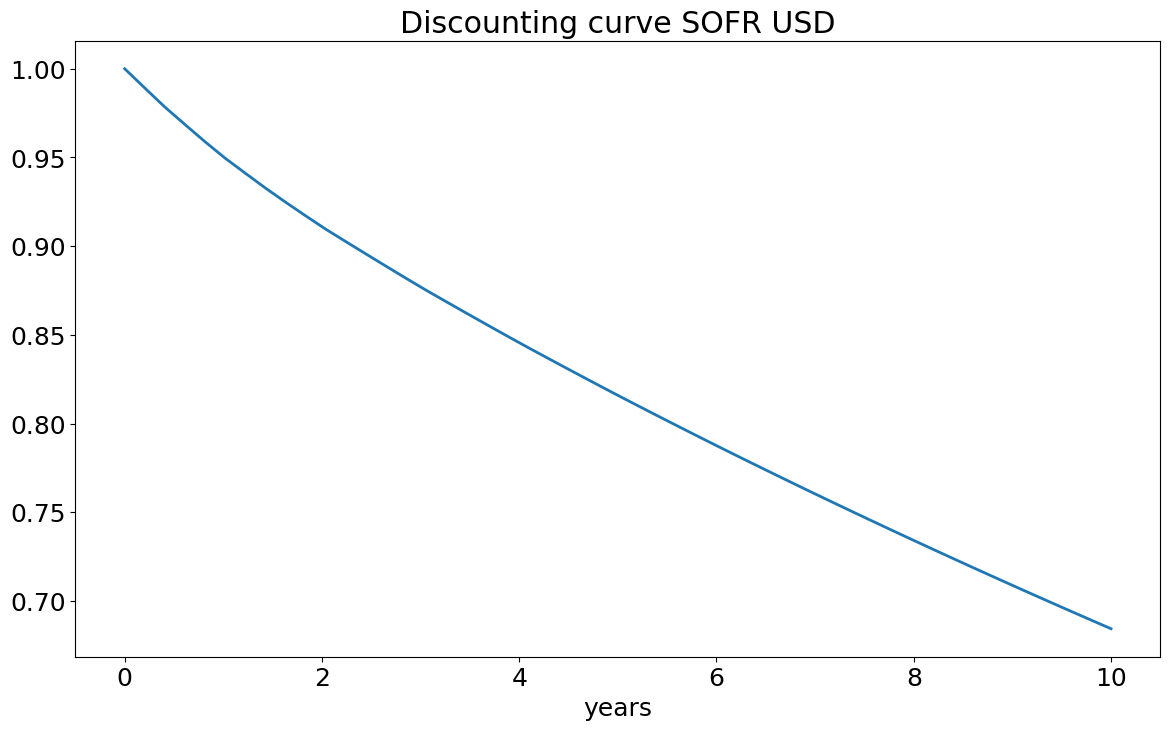

In [17]:
# example of interpolation
plt.plot(np.linspace(0,10,50),[get_discount_factor(x) for x in np.linspace(0,10,50)])
plt.title('Discounting curve SOFR USD')
plt.xlabel('years')
plt.show()

In [18]:
# Code for survival and default probabilities calcultation
# Hazard rates bootstrapping
# Visualizing metrics
# taken from CQF Python lab 17

def get_survival_probability(maturity, discountfactor, spread, recovery, plot_prob=False, plot_hazard=False):
    
    # subsume list of inputs into a dataframe
    df = pd.DataFrame({'Maturity': maturity, 'Df': discountfactor, 'Spread': spread})
    
    # convert bps to decimal
    df['Spread'] = df['Spread']/10000

    # specify delta_t
    df['Dt'] = df['Maturity'].diff().fillna(0)

    # loss rate
    L = 1.0 - recovery
    
    # initialize the variables
    term = term1 = term2 = divider = 0
    
    for i in range(0, len(df.index)):
        if i == 0: df.loc[i,'Survival'] = 1; df.loc[i, 'Hazard'] = 0
        if i == 1: df.loc[i,'Survival'] = L / (L+df.loc[i,'Dt']*df.loc[i,'Spread']); \
            df.loc[i, 'Hazard'] = -np.log(df.loc[i,'Survival']/df.loc[i-1,'Survival'])/df.loc[i,'Dt']
        if i > 1:
            terms = 0
            for j in range(1, i):
                term = df.loc[j,'Df']*(L*df.loc[j-1,'Survival'] - \
                                              (L + df.loc[j,'Dt']*df.loc[i,'Spread'])* \
                                              df.loc[j,'Survival'])
                terms = terms + term  
           
            divider = df.loc[i,'Df']*(L+df.loc[i,'Dt']*df.loc[i,'Spread'])
            term1 = terms/divider

            term2 = (L*df.loc[i-1,'Survival']) / (L + (df.loc[i,'Dt'] * df.loc[i,'Spread']))

            df.loc[i,'Survival'] = term1 + term2
            
            if (df.loc[i,'Survival'] >= 0 and df.loc[i-1,'Survival'] >= 0):
                df.loc[i, 'Hazard'] = -np.log(df.loc[i,'Survival']/df.loc[i-1,'Survival'])/df.loc[i,'Dt']
    
    # derive probability of default
    df['Default'] = 1. - df['Survival']
    
    # derive marginal probability of default
    df['Marginal'] = df['Survival'].diff().fillna(0)
    
    if plot_prob:
        # plot survival probability
        df[['Survival', 'Default']].iplot(title='Survival vs Default Probability', 
                                          xTitle='CDS Maturity', 
                                          yTitle='Survival Probability', 
                                          secondary_y = 'Default', 
                                          secondary_y_title='Default Probability')
        
    if plot_hazard:
        # plot survival probability
        df['Hazard'].iplot(kind='bar', title='Term Structure of Hazard Rates', 
                                          xTitle='CDS Maturity', 
                                          yTitle='Hazard Rates')

    return df

### 4.2. Hazard rates bootstrapping

In [19]:
# calculate disc factors for each tenor
CDS_market['disc_factors'] = CDS_market['tenor'].apply(lambda x: get_discount_factor(x))

In [20]:
# new rows to be added for successful bootstrapping 
new_rows = pd.DataFrame([{'COUNTRY': 'UAE', 'mid': 0, 'tenor': 0, 'disc_factors': 1}, 
                         {'COUNTRY': 'QATAR', 'mid': 0, 'tenor': 0, 'disc_factors': 1},
                         {'COUNTRY': 'SAUDI', 'mid': 0 , 'tenor': 0, 'disc_factors': 1},
                         {'COUNTRY': 'OMAN', 'mid': 0 , 'tenor': 0, 'disc_factors': 1},
                         {'COUNTRY': 'BAHRAIN', 'mid': 0 , 'tenor': 0, 'disc_factors': 1}])

CDS_market = pd.concat([CDS_market, new_rows], ignore_index=True)
CDS_market = CDS_market.fillna('Dummy')

In [21]:
CDS_market = CDS_market.sort_values(['COUNTRY', 'tenor'], ascending=[False, True])
CDS_market

,COUNTRY,BBG ID,CURRENCY,TERM,TICKER,CONTRIBUTOR,BID(bps),ASK(bps),mid,tenor,disc_factors
40,UAE,Dummy,Dummy,Dummy,Dummy,Dummy,Dummy,Dummy,0.0000,0.0,1.000000
24,UAE,12257737.0,USD,6mo,CX967360,CMAN,10.6,15.5,13.0500,0.5,0.973919
25,UAE,12257737.0,USD,1yr,CX855687,CMAN,11.49,15.9,13.6950,1.0,0.950349
26,UAE,12257737.0,USD,2yr,CX855691,CMAN,18.52,22.61,20.5650,2.0,0.910901
27,UAE,12257737.0,USD,3yr,CX855695,CMAN,24.59,28.81,26.7000,3.0,0.876980
28,UAE,12257737.0,USD,4yr,CX855703,CMAN,30.93,35.7,33.3150,4.0,0.845590
29,UAE,12257737.0,USD,5yr,CX855707,CBIN,39.653,43.89,41.7715,5.0,0.815927
30,UAE,12257737.0,USD,7yr,CX855751,CMAN,55.35,60.53,57.9400,7.0,0.760392
31,UAE,12257737.0,USD,10yr,CX855763,CMAN,67.53,74.99,71.2600,10.0,0.684422
42,SAUDI,Dummy,Dummy,Dummy,Dummy,Dummy,Dummy,Dummy,0.0000,0.0,1.000000


In [22]:
# prepare survival data 
# based on the assumption that Recovery Rate is at 40%

Survival_data = pd.DataFrame(columns = ['Country','Maturity','Df','Spread','Dt','Survival','Hazard','Default','Marginal'])

for i in names:
    country = CDS_market[CDS_market.COUNTRY == i].reset_index()
    Survival_data = pd.concat([Survival_data,get_survival_probability(country.tenor,country.disc_factors,country.mid,0.4,plot_prob=False,plot_hazard=False)]) 
    Survival_data.Country[Survival_data.Country.isna()] = i

In [23]:
# write into csv file for futher use
Survival_data.to_csv('Survival_data.csv')

Survival_data

,Country,Maturity,Df,Spread,Dt,Survival,Hazard,Default,Marginal
0,UAE,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
1,UAE,0.5,0.973919,0.001305,0.5,0.998914,0.002174,0.001086,-0.001086
2,UAE,1.0,0.950349,0.001370,0.5,0.997720,0.002391,0.002280,-0.001194
3,UAE,2.0,0.910901,0.002056,1.0,0.993109,0.004633,0.006891,-0.004611
4,UAE,3.0,0.876980,0.002670,1.0,0.986544,0.006632,0.013456,-0.006565
5,UAE,4.0,0.845590,0.003331,1.0,0.977556,0.009152,0.022444,-0.008988
6,UAE,5.0,0.815927,0.004177,1.0,0.964696,0.013243,0.035304,-0.012860
7,UAE,7.0,0.760392,0.005794,2.0,0.931314,0.017608,0.068686,-0.033382
8,UAE,10.0,0.684422,0.007126,3.0,0.881232,0.018425,0.118768,-0.050083
0,QATAR,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000


### 4.3 Survival metrics visualized

In [24]:
# Hazard rate Term structure
h_data = [np.hstack(Survival_data.Hazard[Survival_data.Country==i]) for i in names]
Hazard = pd.DataFrame(np.transpose(h_data), columns = names , index = [str(i)+'Y' for i in Survival_data.Maturity.unique()])
Hazard.iplot(title='Hazard Rate Term Structure', xTitle='CDS Maturity', yTitle='Hazard Rate')

In [25]:
# Survival rate Term structure
s_data = [np.hstack(Survival_data.Survival[Survival_data.Country==i]) for i in names]
Survival = pd.DataFrame(np.transpose(s_data), columns = names , index = [str(i)+'Y' for i in Survival_data.Maturity.unique()])
Survival.iplot(title='Survival Rate Term Structure', xTitle='CDS Maturity', yTitle='Survival Rate')

### 4.4 Effect of recovery rate

Let's have a look at one entity and how a change of recovery rate can affect the calculation

In [26]:
# UAE as an example
UAE = CDS_market[CDS_market.COUNTRY == 'UAE'].reset_index()

In [27]:
#get_survival_probability(UAE.tenor,UAE.disc_factors,UAE.mid,0.25,plot_prob=True,plot_hazard=True)

In [28]:
# plot probabilities for various recovery rate
sp = pd.DataFrame()

for i in np.arange(0.1, 1, 0.1):
    sp[i] = get_survival_probability(UAE.tenor,UAE.disc_factors,UAE.mid,i)['Survival']

sp.columns = np.around(sp.columns*100)
sp.index = [str(i)+'Y' for i in Survival_data.Maturity.unique()]
sp.iplot(title='Survival Probability for various Recovery Rate',
         xTitle='CDS Maturity', 
         yTitle='Survival Probability',
         labels = sp.columns)

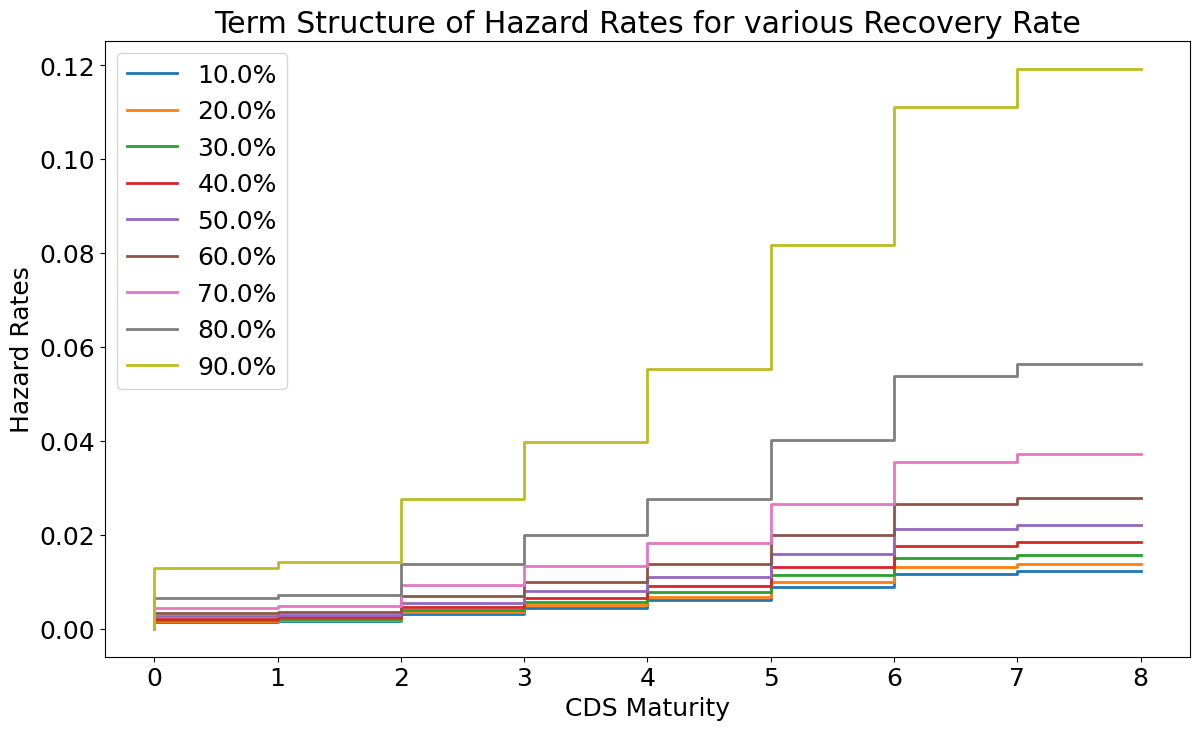

In [29]:
hz = pd.DataFrame()

for i in np.arange(0.1, 1, 0.1):
    hz[i] = get_survival_probability(UAE.tenor,UAE.disc_factors,UAE.mid,i)['Hazard']
    plt.step(hz.index, hz[i], label =f'{i*100:0.4}%')

plt.title('Term Structure of Hazard Rates for various Recovery Rate')
plt.xlabel('CDS Maturity')
plt.ylabel('Hazard Rates')
plt.legend();

In [30]:
# surface plot 
sp.iplot(kind='surface', title='Relationship of Survival Probability, Maturity & Recovery Rate')